<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
import pandas as pd
import numpy as np
import os
import transformers
import seaborn as sns
import torch
import re
from pymystem3 import Mystem
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.utils import shuffle

import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize

import sys

!{sys.executable} -m pip install catboost

import catboost
from catboost import CatBoostClassifier

!{sys.executable} -m pip install spacy
# Download spaCy's  'en' Model
!{sys.executable} -m spacy download en

import spacy

import time
from tqdm.notebook import tqdm

RANDOM_STATE = 711

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.9 MB 2.5 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# функция для загрузки данных
path_1 = '/datasets/toxic_comments.csv'
path_2 = 'C:\\DS\\YP\\S17\\toxic_comments.csv'

def generate_data(path_1, path_2):
    if os.path.exists(path_1):
        df = pd.read_csv(path_1)
    elif os.path.exists(path_2):
        df = pd.read_csv(path_2)
    else:
        print("Something is wrong!")
    return df

In [3]:
#создаём датасет
df = generate_data(path_1, path_2)

In [4]:
# проверка, вывод на экран
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
# вывод информации о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Выведем столбец 'Unnamed: 0'

In [6]:
df['Unnamed: 0']

0              0
1              1
2              2
3              3
4              4
           ...  
159287    159446
159288    159447
159289    159448
159290    159449
159291    159450
Name: Unnamed: 0, Length: 159292, dtype: int64

Вероятно столбец хранит данные о номере комментария. Для модели нам не понадобится. Удалим столбец

In [7]:
df = df.drop('Unnamed: 0', axis=1)
# проверка
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Язык комментариев английский

Выведем уникальные значения столбца 'toxic'

In [8]:
df['toxic'].unique()

array([0, 1])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Веротяно значение "1" означает, что комментарий токсичен, значение "0", что комментарий не токсичен. Для этих двух значений тип данных int64 излишне велик. Изменим тип на int8

In [10]:
df['toxic'] = df['toxic'].astype('int8')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 1.4+ MB


Тем самым снизили размер файла почти в 2 раза

Проверим соотношение тоскичных комментариев и нетоксичных

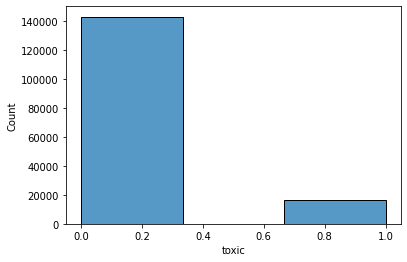

In [12]:
sns.histplot(df['toxic'], bins=3);

Наблюдается большая диспропорция между колчиеством токсичных и нетоксичнх комментариев. При обучении модели потребуется сбалансировать данные.

## Обучение

### Лемматизируем текст

In [13]:
# саздаём функцию для очистки текста от небуквенных символов

def clear_text(text):
    new_text = re.sub(r'[^a-zA-Z]', ' ', text)
    new_text = new_text.split()
    new_text = " ".join(new_text)
  
    return new_text

In [14]:
# читстим текст от небуквенных значений
cleared_text = df['text'].apply(clear_text)


Используем библиотеку SpaCy для лемматизации текста

In [15]:
# Проверим лемматизациюи 
wnl = WordNetLemmatizer()

sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text'])
print(df_my)

def penn2morphy(penntag):
    # придаём POS-теги для слов
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'


tqdm.pandas()
def lemmatize_text(text):
    # текст передаём в нижнем регстире
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

print(df_my['text'].progress_apply(lemmatize_text))

                                                text
0  The striped bats are hanging on their feet for...
1      you should be ashamed of yourself went worked


  0%|          | 0/2 [00:00<?, ?it/s]

0    [the, striped, bat, be, hang, on, their, foot,...
1    [you, should, be, ashamed, of, yourself, go, w...
Name: text, dtype: object


В целом лемматизацая с помощью WordNetLemmatizer работает хорошо

In [16]:
# лемматизация текста

tqdm.pandas()
df['lemm_text'] = cleared_text.progress_apply(lemmatize_text)

df = df.drop(['text'], axis=1)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [17]:
cleared_text

0         Explanation Why the edits made under my userna...
1         D aww He matches this background colour I m se...
2         Hey man I m really not trying to edit war It s...
3         More I can t make any real suggestions on impr...
4         You sir are my hero Any chance you remember wh...
                                ...                        
159287    And for the second time of asking when your vi...
159288    You should be ashamed of yourself That is a ho...
159289    Spitzer Umm theres no actual article for prost...
159290    And it looks like it was actually you who put ...
159291    And I really don t think you understand I came...
Name: text, Length: 159292, dtype: object

In [18]:
df['lemm_text']

0         [explanation, why, the, edits, make, under, my...
1         [d, aww, he, match, this, background, colour, ...
2         [hey, man, i, m, really, not, try, to, edit, w...
3         [more, i, can, t, make, any, real, suggestion,...
4         [you, sir, be, my, hero, any, chance, you, rem...
                                ...                        
159287    [and, for, the, second, time, of, ask, when, y...
159288    [you, should, be, ashamed, of, yourself, that,...
159289    [spitzer, umm, theres, no, actual, article, fo...
159290    [and, it, look, like, it, be, actually, you, w...
159291    [and, i, really, don, t, think, you, understan...
Name: lemm_text, Length: 159292, dtype: object

In [19]:
def func (df):
    df['lemm_text'].apply(lambda x: ' '.join(x))

df['lemm_text'] = [" ".join(review) for review in df['lemm_text'].values]

In [20]:
df['lemm_text']

0         explanation why the edits make under my userna...
1         d aww he match this background colour i m seem...
2         hey man i m really not try to edit war it s ju...
3         more i can t make any real suggestion on impro...
4         you sir be my hero any chance you remember wha...
                                ...                        
159287    and for the second time of ask when your view ...
159288    you should be ashamed of yourself that be a ho...
159289    spitzer umm theres no actual article for prost...
159290    and it look like it be actually you who put on...
159291    and i really don t think you understand i come...
Name: lemm_text, Length: 159292, dtype: object

Разобьём выборку на тренировочную, валидную и тестовую в соотношении 50/25/25

In [21]:
# Разобьём выборку в соотношении 50/25/25. Уменьшим количество кроссвалидаций до 3 из-за размера выборки.
X = df.drop('toxic', axis=1)
y = df['toxic']

X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                     test_size=0.5,
                                                     random_state=RANDOM_STATE)

X_valid, X_test, y_valid, y_test = train_test_split(X_valid,
                                                   y_valid,
                                                   test_size=0.5,
                                                   random_state=RANDOM_STATE)

# уменьшаем размер кросс-валидации
cv_counts = 2

In [22]:
# загружаем стоп-слова из словаря ntlk
nltk.download('stopwords')
stopwords = list(nltk_stopwords.words('english'))

#создаём модель векторизации
count_tf_idf = TfidfVectorizer(stop_words=stopwords)


#векторизируем признаки с учётом стоп-слов и переводим значения в юникод

X_train = count_tf_idf.fit_transform(X_train['lemm_text'])
X_valid = count_tf_idf.transform(X_valid['lemm_text'])
X_test  = count_tf_idf.transform(X_test['lemm_text'])



[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
cv_counts = 2

(79646, 103055)
(39823, 103055)
(39823, 103055)


**Вывод**
Данные не сбалансированы. Далее проведём балансировку данных несклькольми способами и сравним.

### Обучение моделей

Далее подберём оптимальные гиперпараметры модели. В логистической регресси будем менять параметры "penalty" и "solver" и значение балансировки

### Логистическая регрессия

In [24]:
class_ratio = df['toxic'].value_counts()[0]/df['toxic'].value_counts()[1]
dict_classes={0:1, 1:class_ratio}

list_C = [5.0, 10.0, 15.0]
list_penalty = ['l1', 'l2']
list_weight = ['None', 'dict_classes', 'balanced']

model_table = pd.DataFrame(columns = ['модель', 'C', 'penalty', 'class_weight' 'cv_f1_LR', 'F1'])

for C in tqdm(list_C):
    for penalty in tqdm(list_penalty):
        for weight in tqdm(list_weight):
            model = LogisticRegression(C=C, penalty=penalty, class_weight=weight, solver='saga')
            model.fit(X_train, y_train)
            predictions = model.predict(X_valid)
            f1 = f1_score(y_valid, predictions)
            cv_f1_LR = cross_val_score(model,
                        X_train, 
                        y_train, 
                        cv=cv_counts, 
                        scoring='f1').mean()
            print(f"Значение f1 при С = {C}, penalty = {penalty} и балансировке = {weight}:", f1)
            print(f"Значение f1 на CV при С = {C}, penalty = {penalty} и балансировке = {weight}:", cv_f1_LR)
            new_row = ['логистическая регрессия', C, penalty, weight, cv_f1_LR, f1]
            model_table = model_table.append({'модель': 'логистическая регрессия',
                                'C' : C,
                                'penalty' : penalty,
                                'class_weight' : weight,
                                'cv_f1_LR' : cv_f1_LR,
                                'F1' : f1},
                                ignore_index=True)




  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Значение f1 при С = 5.0, penalty = l1 и балансировке = None: 0.7742279020234291
Значение f1 на CV при С = 5.0, penalty = l1 и балансировке = None: 0.7497868192646122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Значение f1 при С = 5.0, penalty = l1 и балансировке = dict_classes: 0.774167776298269
Значение f1 на CV при С = 5.0, penalty = l1 и балансировке = dict_classes: 0.7498938379082344


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Значение f1 при С = 5.0, penalty = l1 и балансировке = balanced: 0.7444407930770073
Значение f1 на CV при С = 5.0, penalty = l1 и балансировке = balanced: 0.7352821834738881


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


  0%|          | 0/3 [00:00<?, ?it/s]

Значение f1 при С = 5.0, penalty = l2 и балансировке = None: 0.759564367495113
Значение f1 на CV при С = 5.0, penalty = l2 и балансировке = None: 0.7137618229720719
Значение f1 при С = 5.0, penalty = l2 и балансировке = dict_classes: 0.759564367495113
Значение f1 на CV при С = 5.0, penalty = l2 и балансировке = dict_classes: 0.7138043733753264


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Значение f1 при С = 5.0, penalty = l2 и балансировке = balanced: 0.7518632178868917
Значение f1 на CV при С = 5.0, penalty = l2 и балансировке = balanced: 0.7403545743463611


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Значение f1 при С = 10.0, penalty = l1 и балансировке = None: 0.7687838373167832
Значение f1 на CV при С = 10.0, penalty = l1 и балансировке = None: 0.7444100330727206


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Значение f1 при С = 10.0, penalty = l1 и балансировке = dict_classes: 0.768682334301558
Значение f1 на CV при С = 10.0, penalty = l1 и балансировке = dict_classes: 0.744539595877871


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Значение f1 при С = 10.0, penalty = l1 и балансировке = balanced: 0.7571683521713265
Значение f1 на CV при С = 10.0, penalty = l1 и балансировке = balanced: 0.7393090292567341


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


  0%|          | 0/3 [00:00<?, ?it/s]

Значение f1 при С = 10.0, penalty = l2 и балансировке = None: 0.7635116598079561
Значение f1 на CV при С = 10.0, penalty = l2 и балансировке = None: 0.7257110211195461
Значение f1 при С = 10.0, penalty = l2 и балансировке = dict_classes: 0.7635116598079561
Значение f1 на CV при С = 10.0, penalty = l2 и балансировке = dict_classes: 0.7257110211195461


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Значение f1 при С = 10.0, penalty = l2 и балансировке = balanced: 0.7055807533030961
Значение f1 на CV при С = 10.0, penalty = l2 и балансировке = balanced: 0.7387301906470753


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Значение f1 при С = 15.0, penalty = l1 и балансировке = None: 0.764968487394958
Значение f1 на CV при С = 15.0, penalty = l1 и балансировке = None: 0.7422201609948932


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Значение f1 при С = 15.0, penalty = l1 и балансировке = dict_classes: 0.7649067507223536
Значение f1 на CV при С = 15.0, penalty = l1 и балансировке = dict_classes: 0.7423022189789923


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Значение f1 при С = 15.0, penalty = l1 и балансировке = balanced: 0.75418860698899
Значение f1 на CV при С = 15.0, penalty = l1 и балансировке = balanced: 0.7405674162399674


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


  0%|          | 0/3 [00:00<?, ?it/s]

Значение f1 при С = 15.0, penalty = l2 и балансировке = None: 0.7648339684267829
Значение f1 на CV при С = 15.0, penalty = l2 и балансировке = None: 0.7282479988776602
Значение f1 при С = 15.0, penalty = l2 и балансировке = dict_classes: 0.7648339684267829
Значение f1 на CV при С = 15.0, penalty = l2 и балансировке = dict_classes: 0.7282479988776602


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Значение f1 при С = 15.0, penalty = l2 и балансировке = balanced: 0.7533621798620044
Значение f1 на CV при С = 15.0, penalty = l2 и балансировке = balanced: 0.731436129064762


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [25]:
print(model_table)

                     модель     C penalty  class_weightcv_f1_LR        F1  \
0   логистическая регрессия   5.0      l1                   NaN  0.774228   
1   логистическая регрессия   5.0      l1                   NaN  0.774168   
2   логистическая регрессия   5.0      l1                   NaN  0.744441   
3   логистическая регрессия   5.0      l2                   NaN  0.759564   
4   логистическая регрессия   5.0      l2                   NaN  0.759564   
5   логистическая регрессия   5.0      l2                   NaN  0.751863   
6   логистическая регрессия  10.0      l1                   NaN  0.768784   
7   логистическая регрессия  10.0      l1                   NaN  0.768682   
8   логистическая регрессия  10.0      l1                   NaN  0.757168   
9   логистическая регрессия  10.0      l2                   NaN  0.763512   
10  логистическая регрессия  10.0      l2                   NaN  0.763512   
11  логистическая регрессия  10.0      l2                   NaN  0.705581   

Максимальное значение f1 = 0.774228 добились при таких параметрах Значение f1 при С = 5.0, penalty = l1 и балансировке = None: 

In [26]:
# Присвоим лучшее значение f1 переменной valid_f1_LR для будущего сравнения
valid_f1_LR = 0.7740218259249401
cv_f1_LR = 0.749752


### Решающее дерево

обучим модель решающее дерево

In [27]:
best_depth = 0
best_result = 0
best_cv_result = 0
best_model = None 
for depth in range(2, 26, 2):
    model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth = depth, class_weight=dict_classes) # обучение модели с заданной глубиной
    model_tree.fit(X_train, y_train) # обучение модели на тренировочной выборке
    predictions = model_tree.predict(X_valid) # подсчёт качества модели на валидационной выборке
    result = f1_score(y_valid, predictions)

    if result > best_result:
        best_result = result
        best_depth = depth

model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth = best_depth, class_weight=dict_classes)        
cv_f1_DT = cross_val_score(model_tree,
                        X_train, 
                        y_train, 
                        cv=cv_counts, 
                        scoring='f1').mean()
         
valid_f1_DT = best_result
print('Лучший параметр f1 на валидации:', best_result)
print('Лучший параметр f1 на CV:', cv_f1_DT)
print('C глубиной:', best_depth)

Лучший параметр f1 на валидации: 0.6045669729880256
Лучший параметр f1 на CV: 0.5975479757912054
C глубиной: 24


### CatBoostClassifier 

Обучим модель CatBoostClassifier 

In [28]:
model_CatBoost = CatBoostClassifier(verbose=False, iterations=250, class_weights=dict_classes)
model_CatBoost.fit(X_train, y_train)
predictions = model_CatBoost.predict(X_valid)
cv_f1_CB = cross_val_score(model_CatBoost,
                            X_train, 
                            y_train, 
                            cv=cv_counts, 
                            scoring='f1').mean()
valid_f1_CB = f1_score(y_valid, predictions)
print('F1 на cv', cv_f1_CB)
print('F1 на валидации', valid_f1_CB)

F1 на cv 0.7346476098955408
F1 на валидации 0.7476739034116083


In [29]:
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'CatBoostClassifier']
data = {'F1 на CV':[cv_f1_LR,
                    cv_f1_DT,
                    cv_f1_CB],
        'F1 на валидации':[valid_f1_LR,
                           valid_f1_DT,
                           valid_f1_CB]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['F1 на валидации'] > 0.75
scores_data

,F1 на CV,F1 на валидации,Выполнение задачи
LogisticRegression,0.749752,0.774022,True
DecisionTreeClassifier,0.597548,0.604567,False
CatBoostClassifier,0.734648,0.747674,False


На тестовых данных будем тестировать логистическую регрессию

Логистическая регрессия показала наилучие результаты из рассматриваемых моделей. 
Длаее логистическую регрессию с гиперпараметрами, которые дали лучший результат на тренировочной выборке, обучим на тестовой выборке.

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Метрики LogisticRegression
ROC AUC: 0.9624230237163651
F1: 0.7815384615384616
Precision: 0.856849515987093
Recall: 0.7183964584358091
Accuracy: 0.9589935464430103



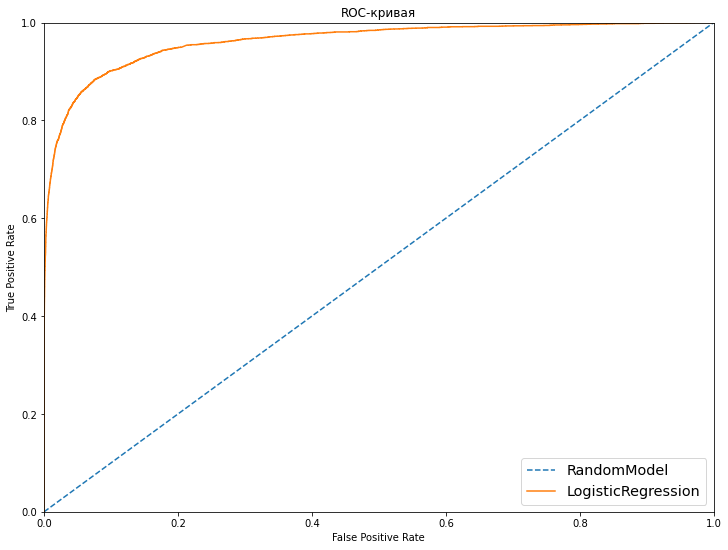

In [31]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = LogisticRegression(C=5.0, penalty='l1',  class_weight='dict_classes', solver='saga')
model.fit(X_train, y_train)
probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
predict_test = model.predict(X_test)
plt.plot(fpr, tpr, label='LogisticRegression')
print('Метрики LogisticRegression')
print('ROC AUC:', roc_auc_score(y_test, probabilities_one_test))
print('F1:', f1_score(y_test, predict_test))
print('Precision:', precision_score(y_test, predict_test))
print('Recall:', recall_score(y_test, predict_test))
print('Accuracy:', accuracy_score(y_test, predict_test))
print()

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

Добились разультата метрики f1 на тестовой выборке 0.753, что удовлетворяем условиям задачи.

## Выводы

Подготовлены данные для обучения. Сформированы выборки для обучения. Выбран способ балансировки данных. Обучены модели выбрана лучшая из них. Проверили модель на тестовой выборке. Модель прошла проверку. Луше всего себя показала логистическая регрессия с гиперпараметрами: C=5.0, penalty='l1',  class_weight='None', solver='saga'